# Rover Analytics 

## Question 5: New Conversation Flow A/B Test

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


In [2]:
AB_df = pd.read_csv("csvs/people_testsegmentation.csv") #read in test dataset
                                                        #note: person_id matches people_person

In [5]:
conversations = pd.read_csv('csvs/conversations_conversation.csv') #read in conversations_conversations dataframe
                                                                   #note: requester_id matches people_person id.
                                                                   #we can likely merge dataframes based on this feature.

In [6]:
conversations.head(1)

,id,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN


In [7]:
webpage_test = AB_df[AB_df['test_name']  == 'New Conversation Flow'] #this gives us the webpage dataframe

In [8]:
test_conversations = pd.merge(left=webpage_test, right=conversations, 
                                  left_on=webpage_test['person_id'], right_on=conversations['requester_id'])

#merge webpage_test dataframe with the conversations dataframe to look at conversations leading to bookings

In [9]:
test_conversations.head() #examine the merge

,key_0,id_x,test_name,test_group,added_x,person_id,id_y,start_date,end_date,units,added_y,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at
0,64393,64394,New Conversation Flow,variant,2018-07-16 10:17:53.460035,64393,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN
1,64392,64395,New Conversation Flow,holdout,2018-08-01 10:20:48.626868,64392,2,2018-08-10,2018-08-16,6,2018-08-01 10:20:48.626868,132,NaN,64392,10126,NaN,NaN
2,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,3,2018-06-16,2018-06-19,3,2018-06-05 16:46:39.542467,168,NaN,64391,20677,NaN,NaN
3,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,4,2018-07-13,2018-07-20,7,2018-07-02 09:12:22.275923,490,NaN,64391,3847,NaN,NaN
4,64389,64397,New Conversation Flow,variant,2018-06-21 16:02:48.694725,64389,5,2018-07-02,2018-07-07,5,2018-06-21 16:02:48.694725,140,NaN,64389,9982,NaN,NaN


In [10]:
no_book = test_conversations['booked_at'].isna()

In [14]:
test_conversations['not_booked'] = no_book.astype(int) #cast boolean no_book as 0s and 1s (0 False and 1 True)

In [15]:
test_conversations_variant = test_conversations[test_conversations['test_group'] == 'variant']

In [16]:
test_conversations_holdout = test_conversations[test_conversations['test_group'] == 'holdout']

In [17]:
def binary_encode(x):
    if x == 'variant':
        return 1
    else:
        return 0

In [18]:
test_conversations['test_group_binary'] = test_conversations['test_group'].apply(lambda x: binary_encode(x))
#label those in the test group as 1, else label 0

In [19]:
def booked_binary(x):
    if x == 1:
        return 0
    else:
        return 1

In [20]:
test_conversations['booked'] = test_conversations['not_booked'].apply(lambda x: booked_binary(x)) 
#label those that booked as a 1, else label 0
                    

In [21]:
test_conversations.head() #check to make sure function is applied correctly

,key_0,id_x,test_name,test_group,added_x,person_id,id_y,start_date,end_date,units,added_y,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at,not_booked,test_group_binary,booked
0,64393,64394,New Conversation Flow,variant,2018-07-16 10:17:53.460035,64393,1,2018-07-26,2018-07-31,5,2018-07-16 10:17:53.460035,120,NaN,64393,4646,NaN,NaN,1,1,0
1,64392,64395,New Conversation Flow,holdout,2018-08-01 10:20:48.626868,64392,2,2018-08-10,2018-08-16,6,2018-08-01 10:20:48.626868,132,NaN,64392,10126,NaN,NaN,1,0,0
2,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,3,2018-06-16,2018-06-19,3,2018-06-05 16:46:39.542467,168,NaN,64391,20677,NaN,NaN,1,0,0
3,64391,64396,New Conversation Flow,holdout,2018-06-05 16:46:39.542467,64391,4,2018-07-13,2018-07-20,7,2018-07-02 09:12:22.275923,490,NaN,64391,3847,NaN,NaN,1,0,0
4,64389,64397,New Conversation Flow,variant,2018-06-21 16:02:48.694725,64389,5,2018-07-02,2018-07-07,5,2018-06-21 16:02:48.694725,140,NaN,64389,9982,NaN,NaN,1,1,0


In [51]:
#group by person and then do t_test on the number of bookings for the two conditions  

In [34]:
sum_bookings = test_conversations.groupby(['requester_id'])['booked'].sum() #aggregate by person

In [35]:
sum_bookings = sum_bookings.reset_index()

In [36]:
holdout_customers = test_conversations_holdout['requester_id']

In [37]:
variant_customers = test_conversations_variant['requester_id']

In [38]:
holdout_sum = sum_bookings[sum_bookings['requester_id'].isin(holdout_customers)]

In [39]:
variant_sum = sum_bookings[sum_bookings['requester_id'].isin(variant_customers)]

In [40]:
overlap = holdout_sum[holdout_sum['requester_id'].isin(variant_sum['requester_id'])]

In [41]:
overlap #check for no overlap between holdout and variant customers

,requester_id,booked


In [42]:
sum(~webpage_test['person_id'].isin(test_conversations['requester_id']))#check to make sure we aren't missing any test
                                                                        #cases

0

In [43]:
import statsmodels.stats.weightstats as sm

In [52]:
t_test = stats.ttest_ind(holdout_sum['booked'], variant_sum['booked'], equal_var=False)
t_test

Ttest_indResult(statistic=-6.263220796765503, pvalue=3.8368528298251014e-10)

In [47]:
len(holdout_sum) + len(variant_sum) -2 #degrees of freedom

23383

#### With t(23383) = -6.26 and p< 0.0001, reject the null of no difference in mean booking rates between variant and holdout groups.

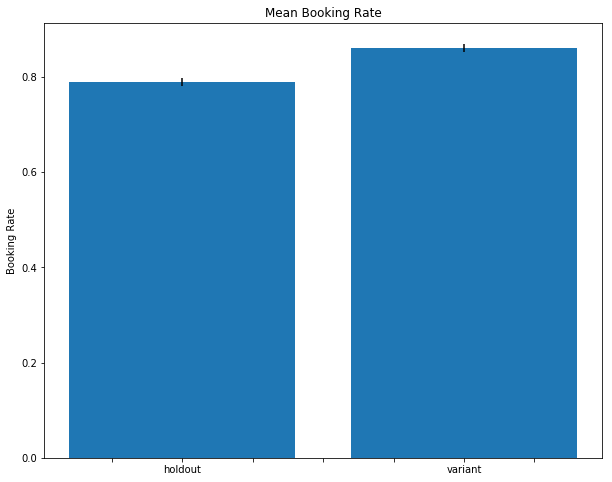

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
x = [1, 2]
y = [holdout_sum['booked'].mean(), variant_sum['booked'].mean()]
std_err = [holdout_sum['booked'].sem(), variant_sum['booked'].sem()]
ax.bar(x, y, yerr=std_err)
ax.set_xticklabels(['','','holdout','', '','','variant',''])
ax.set_ylabel("Booking Rate")
_x=ax.set_title("Mean Booking Rate")

###  Look to see if date ranges differ between the groups.

In [55]:
test_conversations_holdout['added_y'].min()

'2016-08-25 13:35:19.463908'

In [56]:
test_conversations_variant['added_y'].max()

'2018-08-01 22:00:42.098222'

In [57]:
test_conversations_variant['added_y'].min()

'2016-08-16 17:19:08.491864'

In [58]:
test_conversations_variant['added_y'].max()

'2018-08-01 22:00:42.098222'